### Imports

In [1]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_TRAIN, FOREX_DATA_PATH_TEST, FOREX_DATA_PATH, STOCKS_DATA_PATH, FOREX_DATA_PATH_PRODUCTION
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from datetime import datetime, timedelta
import time
import torch
import pickle

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-unhedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-unhedge-v0 alr

# Parameters

In [2]:

# unpack the pickle file and load the data that is in symbols_forex.pkl
with open('C:/Users/WilliamFetzner/Documents/Trading/gym_mtsim_forked/gym_mtsim/data/symbols_forex.pkl', 'rb') as f:
    symbols = pickle.load(f)
# convert symbols to a pd.dataframe
# symbols[1]['EURUSD']
split = int(len(symbols[1]['EURUSD']) * 0.80)
validation_split = int(len(symbols[1]['EURUSD']) * 0.90)

In [3]:
# get the 2 weeks of the symbols[1]['EURUSD'] dataframe by first finding the max date
# then subtracting 14 days from that date
symbols[1]['EURUSD'].index = pd.to_datetime(symbols[1]['EURUSD'].index)
max_date = symbols[1]['EURUSD'].index.max()

In [4]:
# find the previous friday before max_date
# what is the day of the week of the max_date
max_day_of_week = max_date.dayofweek
# subtract the day of the week from the max_date to get the previous friday
max_friday = max_date - pd.DateOffset(days=max_day_of_week+2)
two_weeks = max_friday - pd.DateOffset(days=14)
one_week = max_friday - pd.DateOffset(days=7)

In [5]:
training_index_slice = symbols[1]['EURUSD'].loc[:one_week, :].index
validation_index_slice = symbols[1]['EURUSD'].loc[one_week:max_friday, :].index

In [6]:
validation_index_slice

DatetimeIndex(['2024-04-08 00:00:00+00:00', '2024-04-08 01:00:00+00:00',
               '2024-04-08 02:00:00+00:00', '2024-04-08 03:00:00+00:00',
               '2024-04-08 04:00:00+00:00', '2024-04-08 05:00:00+00:00',
               '2024-04-08 06:00:00+00:00', '2024-04-08 07:00:00+00:00',
               '2024-04-08 08:00:00+00:00', '2024-04-08 09:00:00+00:00',
               ...
               '2024-04-12 14:00:00+00:00', '2024-04-12 15:00:00+00:00',
               '2024-04-12 16:00:00+00:00', '2024-04-12 17:00:00+00:00',
               '2024-04-12 18:00:00+00:00', '2024-04-12 19:00:00+00:00',
               '2024-04-12 20:00:00+00:00', '2024-04-12 21:00:00+00:00',
               '2024-04-12 22:00:00+00:00', '2024-04-12 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=120, freq=None)

### Create Env

In [7]:
sim_train = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

In [8]:
env_train = MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(training_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [9]:
sim_validation = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation = MtEnv(
    original_simulator=sim_validation,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(validation_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

### Define Functions

In [10]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards

def my_profit_calculation(env_orders, stop_loss):
        # env_orders = env_testing.render()['orders']
        # stop_loss = 0.001

        # normalize the Volume with to have a mean of 1
        mean_value = env_orders['Volume'].mean()

        # Normalize the column to have a mean of 1
        env_orders.loc[:, 'Volume_normalized'] = round((env_orders['Volume'] / mean_value), 2)
        # add a column for when the difference between the Entry Price and the Exit Price is greater than stop_loss
        env_orders.loc[:, 'stoploss_hit'] = np.where((env_orders['Type'].str.strip() == 'Buy') &
                                                        ((env_orders['Entry Price'] - env_orders['Exit Price']) > stop_loss),
                                                        1, np.where((env_orders['Type'].str.strip() == 'Sell') &
                                                                        ((env_orders['Exit Price'] - env_orders['Entry Price']) > stop_loss),
                                                                        1, 0))
        env_orders.loc[:, 'Exit Price'] = np.where((env_orders['Type'].str.strip() == 'Buy') & (env_orders['stoploss_hit'] == 1),
                                                        env_orders['Entry Price'] - stop_loss,
                                                        np.where((env_orders['Type'].str.strip() == 'Sell') & (env_orders['stoploss_hit'] == 1),
                                                                env_orders['Entry Price'] + stop_loss, env_orders['Exit Price']))
        env_orders.loc[:, 'Profit'] = np.where((env_orders['Type'].str.strip() == 'Buy'),
                                                        ((env_orders['Exit Price'] - (env_orders['Fee']/2)) - 
                                                        (env_orders['Entry Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume_normalized'], 
                                                        np.where((env_orders['Type'].str.strip() == 'Sell'),
                                                                ((env_orders['Entry Price'] - (env_orders['Fee']/2)) - 
                                                                (env_orders['Exit Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume_normalized'], np.nan))
        total_reward = env_orders.loc[:, 'Profit'].sum()
        # Calculate Gross Profit
        gross_profit = env_orders.loc[env_orders['Profit'] > 0, 'Profit'].sum()

        # Calculate Gross Loss
        gross_loss = env_orders.loc[env_orders['Profit'] < 0, 'Profit'].abs().sum()

        # Calculate Profit Factor
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else 0

        profit_factor = profit_factor - 1

        return profit_factor, total_reward, env_orders

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [11]:
data_path = 'C:/Users/WilliamFetzner/Documents/Trading/gym_mtsim_forked/gym_mtsim/data/symbols_forex_1hr_1_1_24_4_25_24 copy.pkl'
new_data_path = data_path.replace('copy', 'validation')

In [12]:
def normalize_to_range(x, x_min, x_max):
    m = (2 - 0) / (x_max - x_min)
    b = 2
    y = m * (x - x_min)
    return y

def my_get_modified_volume(env, symbol: str, volume: float) -> float:
    si = env.simulator.symbols_info[symbol]
    v = abs(volume)
    v = normalize_to_range(v, si.volume_min, 100)
    v = np.clip(v, si.volume_min, si.volume_max)
    v = round(v / si.volume_step) * si.volume_step
    return v

In [15]:
sim_validation_2 = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=new_data_path
)

class MyMtEnv(MtEnv):
    _get_modified_volume = my_get_modified_volume

env_validation_2 = MyMtEnv(
    original_simulator=sim_validation_2,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(validation_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [14]:
# with open(data_path, 'rb') as f:
#     symbols = pickle.load(f)
# current_data = symbols[1]['EURUSD']
# current_data.index = pd.to_datetime(current_data.index)
# current_data_validation_index = current_data[env_validation_2.time_points[0]:env_validation_2.time_points[-1]]
# symbols[1]['EURUSD'] = current_data_validation_index
# new_data_path = data_path.replace('copy', 'validation')
# with open(new_data_path , 'wb') as f:
#     pickle.dump(symbols, f)

In [16]:
print(env_validation_2.time_points[-1], sim_validation_2.symbols_data['EURUSD'].index[-1], 
      env_validation_2.time_points[0], sim_validation_2.symbols_data['EURUSD'].index[0])

2024-04-12 23:00:00+00:00 2024-04-12 23:00:00+00:00 2024-04-08 00:00:00+00:00 2024-04-08 00:00:00+00:00


In [17]:
with open(STOCKS_DATA_PATH, 'rb') as f:
    symbols_new = pickle.load(f)
new_data = symbols_new[1]['EURUSD']
new_data

,Open,Close,Low,High,Volume
Time,,,,,
2024-01-02 00:00:00+00:00,1.10437,1.10439,1.10411,1.10451,375
2024-01-02 01:00:00+00:00,1.10441,1.10364,1.10354,1.10447,2207
2024-01-02 02:00:00+00:00,1.10364,1.10381,1.10340,1.10384,2376
2024-01-02 03:00:00+00:00,1.10380,1.10347,1.10340,1.10432,5079
2024-01-02 04:00:00+00:00,1.10348,1.10187,1.10180,1.10358,5520
...,...,...,...,...,...
2024-04-26 19:00:00+00:00,1.06856,1.06945,1.06838,1.06963,1378
2024-04-26 20:00:00+00:00,1.06945,1.06941,1.06931,1.06979,884
2024-04-26 21:00:00+00:00,1.06941,1.07054,1.06936,1.07057,883


In [87]:

# sim_validation_2.download_data(
#     symbols=['EURUSD', 'AUDCHF', 'NZDCHF', 'GBPNZD', 'USDCAD'],
#     time_range=(
#         week_ago,
#         current_time
#     ),
#     timeframe=Timeframe.H1
# )
# sim_validation_2.save_symbols('C:/Users/WilliamFetzner/Documents/Trading/gym_mtsim_forked/gym_mtsim/data/symbols_stocks_production.pkl')

In [18]:
def get_latest_data(path_to_data, instrument='EURUSD'):
    with open(path_to_data, 'rb') as f:
        symbols = pickle.load(f)
    current_data = symbols[1][instrument]
    new_data_fil = new_data[new_data.index > max(current_data.index)]
    current_data_new_week_added = pd.concat([current_data, new_data_fil.iloc[[0], :]])
    symbols[1][instrument] = current_data_new_week_added
    # resave the symbols back to a pickle file
    with open(path_to_data, 'wb') as f:
        pickle.dump(symbols, f)

    return len(new_data_fil)

In [19]:
# test which version of the model to take, does it make a difference whether I use model_0 or model_9
# obs_tr, info_tr = env_train.reset(seed=seed)
seed=2024
obs_test, info_test = env_validation_2.reset(seed=seed)
num_episodes = 1000

total_reward = 0
done_test = False
reward_over_tests = {}

# obs_test, info_test = env_validation_2.reset(seed=seed)
model_ppo = PPO.load(f'best_hyperparameters/models_4_27_24/model_250K_0.pkl', env_train)
done_test = False
actions = []
orders_info = []
rewards = []
i = 0
length_new_data = None
while not done_test:
    print('new loop')
    action, _states = model_ppo.predict(obs_test)
    hold_probability = np.random.choice([0, 1])
    if hold_probability == 1:
        print('hold action changed')
        action2 = 0.99
        action[-2] = action2
    # vec_env = model_ppo.get_env()
    actions.append(action)
    if (len(env_validation_2.time_points) - 2) == env_validation_2._current_tick:
        print(env_validation_2._current_tick, obs_test['features'].shape)
        length_new_data = get_latest_data(new_data_path)
        print(length_new_data)
        sim_validation_2.load_symbols(new_data_path)
        env_validation_2.time_points = list(sim_validation_2.symbols_data['EURUSD'].index)
        env_validation_2._end_tick = len(env_validation_2.time_points) - 1
        env_validation_2.signal_features = env_validation_2._process_data()
        env_validation_2.prices = env_validation_2._get_prices()
        env_validation_2.features_shape = (env_validation_2.window_size, env_validation_2.signal_features.shape[1])
        i += 1
    obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation_2.step(action)
    print(len(info_test['orders']['EURUSD']))
    orders_info.append(info_test['orders']['EURUSD'])
    if (length_new_data != None) & (length_new_data == 0):
        truncated_test = True
    if i == 2:
        terminated_test = True


    done_test = terminated_test or truncated_test
    
    total_reward += reward_test
    if done_test:
        break
try:
    orders_made_in_episode_test = env_validation_2.render()['orders']
    # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
    order_len = len(orders_made_in_episode_test)
    total_reward, total_profit, orders_df = my_profit_calculation(orders_made_in_episode_test, 0.001)
    rewards.append(total_profit)
except Exception as e:
    print('Error: ', e)
    order_len = 0

11
11
hold action changed
11
hold action changed
11
hold action changed
11
11
hold action changed
11
hold action changed
11
11
hold action changed
11
11
11
hold action changed
11
11
11
hold action changed
11
11
hold action changed
11
11
11
11
hold action changed
11
hold action changed
11
11
hold action changed
11
11
hold action changed
11
hold action changed
11
hold action changed
11
hold action changed
11
hold action changed
11
hold action changed
11
11
11
11
hold action changed
11
11
hold action changed
11
11
11
hold action changed
11
hold action changed
11
11
11
hold action changed
11
11
11
11
11
hold action changed
11
11
11
hold action changed
11
hold action changed
11
11
11
hold action changed
11
11
11
11
hold action changed
11
hold action changed
11
hold action changed
11
11
11
11
11
hold action changed
11
11
hold action changed
11
11
hold action changed
11
11
hold action changed
11
11
hold action changed
11
11
hold action changed
11
hold action changed
11
hold action changed
11


In [77]:
# action, _states = model_ppo.predict(obs_test)
# obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation_2.step(action)

In [20]:
print(len(orders_info), len(actions))

111 111


In [21]:
orders_info

[{'order_id': 1,
  'symbol': 'EURUSD',
  'hold_probability': 4.590214688536857e-13,
  'hold': False,
  'volume': 100.0,
  'capacity': 2,
  'order_type': <OrderType.Buy: 1>,
  'modified_volume': 2.0,
  'fee': 0.0001277997959638211,
  'margin': 2166.78,
  'error': ''},
 {'order_id': None,
  'symbol': 'EURUSD',
  'hold_probability': 0.9991639861819154,
  'hold': True,
  'volume': 100.0,
  'capacity': 1,
  'order_type': None,
  'modified_volume': 2.0,
  'fee': nan,
  'margin': nan,
  'error': ''},
 {'order_id': None,
  'symbol': 'EURUSD',
  'hold_probability': 0.6899744811276125,
  'hold': True,
  'volume': -100.0,
  'capacity': 1,
  'order_type': None,
  'modified_volume': 2.0,
  'fee': nan,
  'margin': nan,
  'error': ''},
 {'order_id': None,
  'symbol': 'EURUSD',
  'hold_probability': 0.6899744811276125,
  'hold': True,
  'volume': 100.0,
  'capacity': 1,
  'order_type': None,
  'modified_volume': 2.0,
  'fee': nan,
  'margin': nan,
  'error': ''},
 {'order_id': None,
  'symbol': 'EURUS

In [31]:
# env_validation_2.time_points[-1]

Timestamp('2024-04-15 03:00:00+0000', tz='UTC')

In [22]:
len(sim_validation_2.symbols_data['EURUSD'])

122

In [23]:
# replace all the values in one of the orders_info dictionaries with None 
blank = {'order_id': np.nan,
 'symbol': '',
 'hold_probability': np.nan,
 'hold': False,
 'volume': np.nan,
 'capacity': np.nan,
 'order_type': '',
 'modified_volume': np.nan,
 'fee': np.nan,
 'margin': np.nan,
 'error': ''}

In [24]:
blank_list = []
for i in range(9):
    blank_list.append(blank)

In [25]:
orders_info_w_blanks = blank_list + orders_info + blank_list[:2]

In [26]:
orders_info_w_blanks_df = pd.DataFrame(orders_info_w_blanks)
# add 9 blank rows to the top
# orders_info_w_blanks_df = pd.concat([pd.DataFrame(np.zeros((9, orders_info_w_blanks_df.shape[1]))), orders_info_w_blanks_df], axis=0)
# add 2 blank rows to the bottom
# orders_info_w_blanks_df = pd.concat([orders_info_w_blanks_df, pd.DataFrame(np.zeros((2, orders_info_w_blanks_df.shape[1])))], axis=0)
orders_info_w_blanks_df = orders_info_w_blanks_df.rename(columns={'volume': 'Attempted_Order_Volume'})
orders_info_w_blanks_df

,order_id,symbol,hold_probability,hold,Attempted_Order_Volume,capacity,order_type,modified_volume,fee,margin,error
0,NaN,,NaN,False,NaN,NaN,,NaN,NaN,NaN,
1,NaN,,NaN,False,NaN,NaN,,NaN,NaN,NaN,
2,NaN,,NaN,False,NaN,NaN,,NaN,NaN,NaN,
3,NaN,,NaN,False,NaN,NaN,,NaN,NaN,NaN,
4,NaN,,NaN,False,NaN,NaN,,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...
117,NaN,EURUSD,6.899745e-01,True,41.976345,0.0,None,0.84,NaN,NaN,cannot add more orders
118,47.0,EURUSD,3.720076e-44,False,100.000000,1.0,1,2.00,0.000134,2127.66,
119,NaN,EURUSD,6.899745e-01,True,-100.000000,1.0,None,2.00,NaN,NaN,
120,NaN,,NaN,False,NaN,NaN,,NaN,NaN,NaN,


In [30]:
orders_info_w_blanks_df[(orders_info_w_blanks_df['hold'] == True) & (orders_info_w_blanks_df['order_type'] == 'Sell')]

,order_id,symbol,hold_probability,hold,Attempted_Order_Volume,capacity,order_type,modified_volume,fee,margin,error


In [28]:
from scipy.special import expit
# add 10 blank arrays to the beginning of actions
blanks = np.zeros(4)
blanks10 = [blanks]*9
actions_w_blanks = blanks10 + actions + [blanks] * 2
sym_data = sim_validation_2.symbols_data['EURUSD']
# merge actions with sym_data
actions_w_blanks_df = pd.DataFrame(actions_w_blanks, columns=['action_1', 'action_2', 'action_3', 'action_4'])
# apply the expit function to each of the action columns
actions_w_blanks_df = actions_w_blanks_df.apply(expit)
sym_data_index_reset = sym_data.reset_index()
sym_with_actions = sym_data_index_reset.merge(actions_w_blanks_df, left_index=True, right_index=True, how='left')
sym_with_actions = sym_with_actions.merge(orders_info_w_blanks_df, left_index=True, right_index=True, how='left')
sym_with_actions

,Time,Open,Close,Low,High,Volume,action_1,action_2,action_3,action_4,...,symbol,hold_probability,hold,Attempted_Order_Volume,capacity,order_type,modified_volume,fee,margin,error
0,2024-04-08 00:00:00+00:00,1.08370,1.08370,1.08348,1.08375,1274,5.000000e-01,5.000000e-01,5.000000e-01,0.5,...,,NaN,False,NaN,NaN,,NaN,NaN,NaN,
1,2024-04-08 01:00:00+00:00,1.08362,1.08276,1.08268,1.08370,578,5.000000e-01,5.000000e-01,5.000000e-01,0.5,...,,NaN,False,NaN,NaN,,NaN,NaN,NaN,
2,2024-04-08 02:00:00+00:00,1.08275,1.08297,1.08275,1.08330,545,5.000000e-01,5.000000e-01,5.000000e-01,0.5,...,,NaN,False,NaN,NaN,,NaN,NaN,NaN,
3,2024-04-08 03:00:00+00:00,1.08297,1.08271,1.08230,1.08300,1229,5.000000e-01,5.000000e-01,5.000000e-01,0.5,...,,NaN,False,NaN,NaN,,NaN,NaN,NaN,
4,2024-04-08 04:00:00+00:00,1.08270,1.08353,1.08269,1.08363,1638,5.000000e-01,5.000000e-01,5.000000e-01,0.5,...,,NaN,False,NaN,NaN,,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2024-04-12 21:00:00+00:00,1.06470,1.06390,1.06389,1.06505,2175,9.912613e-01,1.000000e+00,1.444372e-25,1.0,...,EURUSD,1.444372e-25,False,100.0,2.0,1,2.0,0.000095,2127.80,
118,2024-04-12 22:00:00+00:00,1.06389,1.06383,1.06373,1.06427,1438,6.276312e-26,3.720076e-44,2.157980e-23,1.0,...,EURUSD,2.157980e-23,False,100.0,1.0,1,2.0,0.000088,2127.66,
119,2024-04-12 23:00:00+00:00,1.06380,1.06406,1.06367,1.06438,691,2.238108e-20,1.000000e+00,1.495481e-43,1.0,...,EURUSD,1.495481e-43,False,100.0,1.0,1,2.0,0.000119,2128.12,
120,2024-04-15 00:00:00+00:00,1.06360,1.06338,1.06278,1.06401,988,5.000000e-01,5.000000e-01,5.000000e-01,0.5,...,,NaN,False,NaN,NaN,,NaN,NaN,NaN,


In [31]:
validation_orders = env_validation_2.render()['orders']
validation_orders.sort_values(by='Id')

,Id,Symbol,Type,Volume,Entry Time,Entry Price,Exit Time,Exit Price,Exit Balance,Exit Equity,Profit,Margin,Fee,Closed
46,1,EURUSD,Buy,2.00,2024-04-08 09:00:00+00:00,1.08339,2024-04-08 15:00:00+00:00,1.08342,199980.440041,199751.325664,-19.559959,2166.7800,0.000128,True
45,2,EURUSD,Sell,2.00,2024-04-08 14:00:00+00:00,1.08238,2024-04-08 18:00:00+00:00,1.08527,199381.325664,199376.090433,-599.114376,2164.7600,0.000106,True
42,3,EURUSD,Sell,1.54,2024-04-08 17:00:00+00:00,1.08532,2024-04-08 23:00:00+00:00,1.08585,199125.610891,199057.718922,-94.555232,1671.3928,0.000084,True
44,4,EURUSD,Sell,1.79,2024-04-08 19:00:00+00:00,1.08500,2024-04-08 20:00:00+00:00,1.08578,199220.261980,199136.486748,-161.063684,1942.1500,0.000120,True
43,5,EURUSD,Sell,2.00,2024-04-08 20:00:00+00:00,1.08578,2024-04-08 21:00:00+00:00,1.08572,199220.166123,199145.630891,-0.095858,2171.5600,0.000060,True
41,6,EURUSD,Sell,2.00,2024-04-08 22:00:00+00:00,1.08567,2024-04-08 23:00:00+00:00,1.08585,199057.718922,199057.718922,-67.891969,2171.3400,0.000159,True
40,7,EURUSD,Buy,2.00,2024-04-08 23:00:00+00:00,1.08585,2024-04-09 01:00:00+00:00,1.08601,199076.512181,199076.512181,18.793260,2171.7000,0.000066,True
35,8,EURUSD,Sell,2.00,2024-04-09 01:00:00+00:00,1.08601,2024-04-09 14:00:00+00:00,1.08613,198595.032071,198595.032071,-39.988298,2172.0200,0.000080,True
39,9,EURUSD,Buy,2.00,2024-04-09 03:00:00+00:00,1.08586,2024-04-09 05:00:00+00:00,1.08569,199022.221427,199070.233129,-54.290755,2171.7200,0.000101,True
38,10,EURUSD,Sell,2.00,2024-04-09 05:00:00+00:00,1.08569,2024-04-09 06:00:00+00:00,1.08553,199031.665058,199111.676760,9.443631,2171.3800,0.000113,True


In [30]:
validation_orders['Volume'].unique()

array([2.  , 0.52])

In [31]:
# melt entry time and exit time into a single column called time and keep the Type and Volume columns as well. 
validation_orders_long = validation_orders.melt(id_vars=['Id', 'Type', 'Volume'], value_vars=['Entry Time', 'Exit Time'], var_name='entry/exit', value_name='Time')
validation_orders_long = validation_orders_long.sort_values('Time')
validation_orders_long.loc[:, 'Time'] = pd.to_datetime(validation_orders_long['Time']).dt.tz_localize('UTC')

In [32]:
# change the column name of Volume to Order_Volume
validation_orders_long = validation_orders_long.rename(columns={'Volume': 'Order_Volume'})
validation_orders_long

,Id,Type,Order_Volume,entry/exit,Time
78,1,Buy,2.0,Entry Time,2024-04-08 09:00:00+00:00
81,2,Buy,2.0,Entry Time,2024-04-08 10:00:00+00:00
80,3,Sell,2.0,Entry Time,2024-04-08 11:00:00+00:00
163,2,Buy,2.0,Exit Time,2024-04-08 11:00:00+00:00
162,3,Sell,2.0,Exit Time,2024-04-08 12:00:00+00:00
...,...,...,...,...,...
2,81,Buy,2.0,Entry Time,2024-04-12 22:00:00+00:00
0,82,Buy,2.0,Entry Time,2024-04-12 23:00:00+00:00
84,81,Buy,2.0,Exit Time,2024-04-12 23:00:00+00:00
82,82,Buy,2.0,Exit Time,2024-04-15 00:00:00+00:00


In [33]:
# merge validation_orders_long with sym_with_actions on Time
sym_w_actions_n_orders = sym_with_actions.merge(validation_orders_long, on='Time', how='left')
sym_w_actions_n_orders

,Time,Open,Close,Low,High,Volume,action_1,action_2,action_3,action_4,...,capacity,order_type,modified_volume,fee,margin,error,Id,Type,Order_Volume,entry/exit
0,2024-04-08 00:00:00+00:00,1.08370,1.08370,1.08348,1.08375,1274,5.000000e-01,0.5,5.000000e-01,0.5,...,NaN,,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
1,2024-04-08 01:00:00+00:00,1.08362,1.08276,1.08268,1.08370,578,5.000000e-01,0.5,5.000000e-01,0.5,...,NaN,,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
2,2024-04-08 02:00:00+00:00,1.08275,1.08297,1.08275,1.08330,545,5.000000e-01,0.5,5.000000e-01,0.5,...,NaN,,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
3,2024-04-08 03:00:00+00:00,1.08297,1.08271,1.08230,1.08300,1229,5.000000e-01,0.5,5.000000e-01,0.5,...,NaN,,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
4,2024-04-08 04:00:00+00:00,1.08270,1.08353,1.08269,1.08363,1638,5.000000e-01,0.5,5.000000e-01,0.5,...,NaN,,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2024-04-12 23:00:00+00:00,1.06380,1.06406,1.06367,1.06438,691,2.238108e-20,1.0,1.495481e-43,1.0,...,1.0,1,2.0,0.000119,2128.12,,82.0,Buy,2.0,Entry Time
196,2024-04-12 23:00:00+00:00,1.06380,1.06406,1.06367,1.06438,691,2.238108e-20,1.0,1.495481e-43,1.0,...,1.0,1,2.0,0.000119,2128.12,,81.0,Buy,2.0,Exit Time
197,2024-04-15 00:00:00+00:00,1.06360,1.06338,1.06278,1.06401,988,5.000000e-01,0.5,5.000000e-01,0.5,...,NaN,,NaN,NaN,NaN,,82.0,Buy,2.0,Exit Time
198,2024-04-15 00:00:00+00:00,1.06360,1.06338,1.06278,1.06401,988,5.000000e-01,0.5,5.000000e-01,0.5,...,NaN,,NaN,NaN,NaN,,80.0,Buy,2.0,Exit Time


In [43]:
entry_signals = sym_w_actions_n_orders[(~sym_w_actions_n_orders['Type'].isnull()) & (sym_w_actions_n_orders['entry/exit'] == 'Entry Time')][['action_3']]
entry_signals

,action_3
9,7.763388e-31
10,5.489075e-28
13,3.720076e-44
24,3.720076e-44
48,5.420416e-33
...,...
1450,3.720076e-44
1477,3.720076e-44
1515,1.221224e-11
1528,3.720076e-44


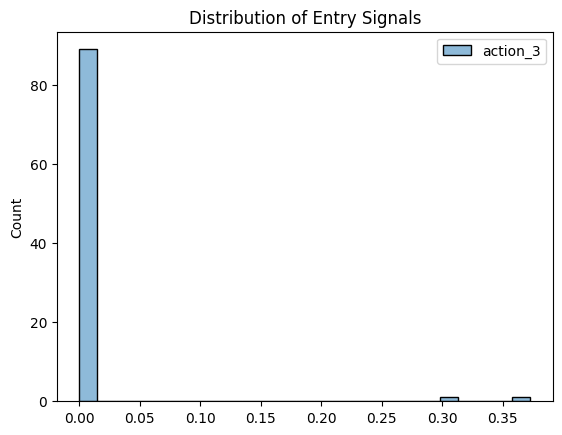

In [46]:
# plot the distribution of entry_signals
sns.histplot(entry_signals, bins=25)
plt.title('Distribution of Entry Signals')
plt.show()

In [48]:
# create a new column for entry_signals that is a 1 if the value is greater than 0.5 and 0 otherwise
sym_w_actions_n_orders.loc[:, 'entry_signal'] = np.where(sym_w_actions_n_orders['action_3'] < 0.5, 1, 0)
sym_w_actions_n_orders


,index,Time,Open,Close,Low,High,Volume,action_1,action_2,action_3,action_4,Type,Order_Volume,entry/exit,entry_signal
0,0,2024-01-02 00:00:00+00:00,1.10437,1.10439,1.10411,1.10451,375,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN,0
1,1,2024-01-02 01:00:00+00:00,1.10441,1.10364,1.10354,1.10447,2207,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN,0
2,2,2024-01-02 02:00:00+00:00,1.10364,1.10381,1.10340,1.10384,2376,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN,0
3,3,2024-01-02 03:00:00+00:00,1.10380,1.10347,1.10340,1.10432,5079,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN,0
4,4,2024-01-02 04:00:00+00:00,1.10348,1.10187,1.10180,1.10358,5520,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,1979,2024-04-25 14:00:00+00:00,1.07247,1.07202,1.07170,1.07298,1273,1.000000e+00,1.000000e+00,4.235503e-27,1.000000e+00,NaN,NaN,NaN,1
2024,1980,2024-04-25 15:00:00+00:00,1.07202,1.07152,1.07149,1.07208,494,1.487540e-10,1.000000e+00,3.974804e-28,3.720076e-44,NaN,NaN,NaN,1
2025,1981,2024-04-25 16:00:00+00:00,1.06927,1.07006,1.06784,1.07037,3843,3.720076e-44,3.720076e-44,1.856950e-01,1.000000e+00,NaN,NaN,NaN,1
2026,1982,2024-04-25 17:00:00+00:00,1.07005,1.07118,1.06927,1.07207,3252,3.720076e-44,1.000000e+00,3.720076e-44,3.720076e-44,NaN,NaN,NaN,1


In [50]:
sym_w_actions_n_orders[sym_w_actions_n_orders['entry_signal'] == 1]

,index,Time,Open,Close,Low,High,Volume,action_1,action_2,action_3,action_4,Type,Order_Volume,entry/exit,entry_signal
9,9,2024-01-02 09:00:00+00:00,1.10286,1.10156,1.10151,1.10381,10969,1.294779e-35,3.720076e-44,7.763388e-31,3.720076e-44,Sell,100.0,Entry Time,1
10,10,2024-01-02 10:00:00+00:00,1.10156,1.10298,1.10156,1.10389,11093,1.000000e+00,3.720076e-44,5.489075e-28,1.000000e+00,Buy,100.0,Entry Time,1
11,10,2024-01-02 10:00:00+00:00,1.10156,1.10298,1.10156,1.10389,11093,1.000000e+00,3.720076e-44,5.489075e-28,1.000000e+00,Sell,100.0,Exit Time,1
12,11,2024-01-02 11:00:00+00:00,1.10298,1.10152,1.10108,1.10380,8370,9.560824e-01,1.000000e+00,3.720076e-44,1.000000e+00,Buy,100.0,Exit Time,1
13,11,2024-01-02 11:00:00+00:00,1.10298,1.10152,1.10108,1.10380,8370,9.560824e-01,1.000000e+00,3.720076e-44,1.000000e+00,Buy,100.0,Entry Time,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022,1978,2024-04-25 13:00:00+00:00,1.07267,1.07247,1.07223,1.07297,1260,3.720076e-44,1.000000e+00,3.720076e-44,3.720076e-44,NaN,NaN,NaN,1
2023,1979,2024-04-25 14:00:00+00:00,1.07247,1.07202,1.07170,1.07298,1273,1.000000e+00,1.000000e+00,4.235503e-27,1.000000e+00,NaN,NaN,NaN,1
2024,1980,2024-04-25 15:00:00+00:00,1.07202,1.07152,1.07149,1.07208,494,1.487540e-10,1.000000e+00,3.974804e-28,3.720076e-44,NaN,NaN,NaN,1
2025,1981,2024-04-25 16:00:00+00:00,1.06927,1.07006,1.06784,1.07037,3843,3.720076e-44,3.720076e-44,1.856950e-01,1.000000e+00,NaN,NaN,NaN,1


In [34]:
# save sym_w_actions_n_orders to excel
sym_w_actions_n_orders.to_csv('sym_w_actions_n_orders2.csv', index=False)